Settings of the notebook: 
- Alpha pareto is fixed to 2
- Delta initialized based on the likelihood value of the centroids of kmeans
- Initial variance of beta is high (50) 

In [31]:
from alpha_fixed_model import mobster_MV

import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy.stats import pareto, beta, uniform, norm, lognorm
import torch
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
import sys
import os

# Set the parent directory
parent_dir = ".."
# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)
from plot_functions import *
from create_beta_pareto_dataset import *
from BoundedPareto import BoundedPareto


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def plot_paretos_1(mb):
    alpha_pareto = mb.params["alpha_pareto"]
    fig, ax = plt.subplots(nrows=alpha_pareto.shape[0], ncols=alpha_pareto.shape[1])
    fig.tight_layout()
    x = np.arange(0,0.5,0.001)
    k = 0
    for d in range(alpha_pareto.shape[1]):
        pdf = pareto.pdf(x, alpha_pareto[k,d], scale=0.01)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d} - alpha {round(float(alpha_pareto[k,d]), ndigits=2)}")

def plot_betas_1(mb):
    phi_beta = mb.params["phi_beta"]
    kappa_beta = mb.params["k_beta"]

    fig, ax = plt.subplots(nrows=phi_beta.shape[0], ncols=phi_beta.shape[1])
    fig.tight_layout()
    x = np.arange(0,1,0.001)
    k = 0
    for d in range(phi_beta.shape[1]):
        a = phi_beta[k,d]*kappa_beta[k,d]
        b = (1-phi_beta[k,d])*kappa_beta[k,d]
        pdf = beta.pdf(x, a, b)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d}")

In [33]:
def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(data, DP, probs_beta, a_beta, b_beta, weights):
    return torch.log(weights) + dist.Beta(a_beta, b_beta).log_prob(probs_beta) + dist.Binomial(total_count=DP, probs = probs_beta).log_prob(data) # simply does log(weights) + log(density)


def pareto_lk(data, DP, probs_pareto, alpha, weights):
    return torch.log(weights) + BoundedPareto(0.01, alpha, 0.55).log_prob(probs_pareto) + dist.Binomial(total_count=DP, probs = probs_pareto).log_prob(data) # simply does log(weights) + log(density)


def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    weights = mb.params["weights"][k]
    if beta == True:
        phi_beta = mb.params["phi_beta"][k, dim]
        k_beta = mb.params["k_beta"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        probs_beta = mb.params["probs_beta"][k, dim]
        return log_sum_exp(beta_lk(NV, DP, probs_beta, a_beta, b_beta, weights)).sum()
    else:
        alpha = mb.params["alpha_pareto"][k, dim]
        probs_pareto = mb.params["probs_pareto"][k, dim]
        return log_sum_exp(pareto_lk(NV, DP, probs_pareto, alpha, weights)).sum()

### 2 beta-pareto components

In [34]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.2
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([1500, 2])
torch.Size([1500, 2])


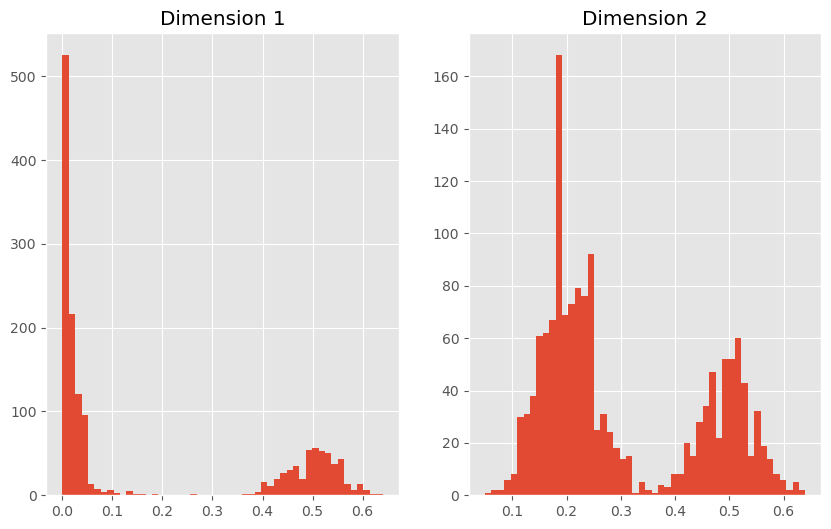

In [35]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [36]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

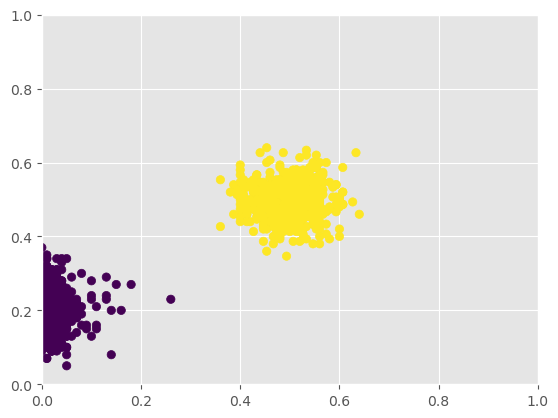

In [37]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])


Text(0.5, 1.0, 'kmeans')

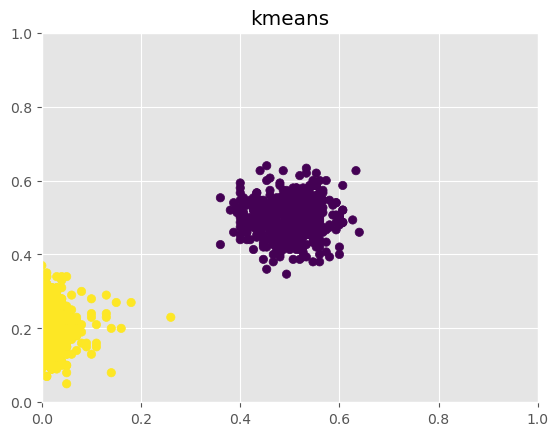

In [38]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("kmeans")

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])
Beta:  tensor([[0.5293, 0.5293],
        [1.3473, 0.7153]])
Pareto:  tensor([[-6.4497, -6.4244],
        [ 3.3633, -3.7040]])
Iteration 0: Loss = 8073724.5
weights_param tensor([0.4247, 0.5753], grad_fn=<DivBackward0>)
phi_beta_param tensor([[0.5019, 0.4979],
        [0.0192, 0.2022]], grad_fn=<AddBackward0>)
k_beta_param tensor([[5.0503, 5.0503],
        [5.0502, 5.0503]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[0.5019, 0.4977],
        [0.0189, 0.1998]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.5019, 0.4977],
        [0.0189, 0.1998]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.0982, 0.9018],
         [0.0982, 0.9018]],

        [[0.9018, 0.0982],
         [0.0982, 0.9018]]], grad_fn=<DivBackward0>)


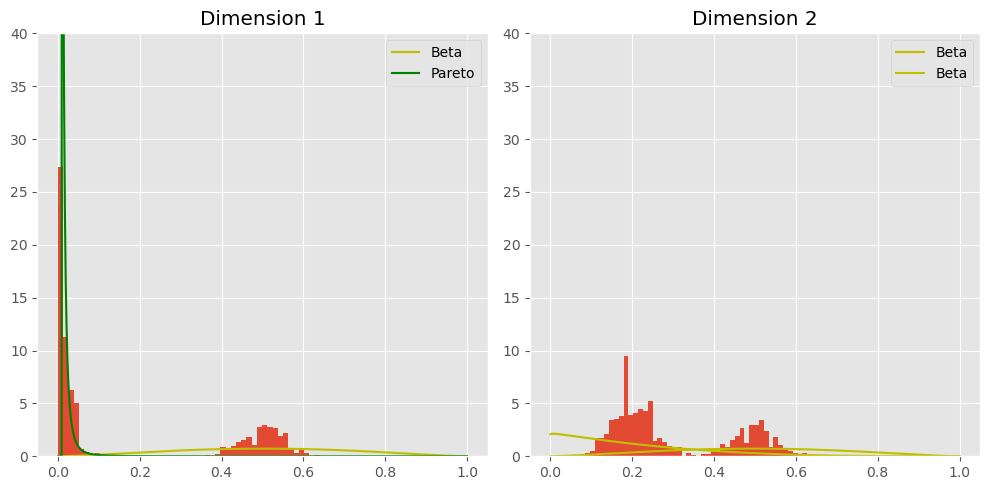

Iteration 200: Loss = 2552362.75
Iteration 400: Loss = -1567726.125
probs_beta [[0.50201386 0.49777436]
 [0.07965483 0.19843996]]


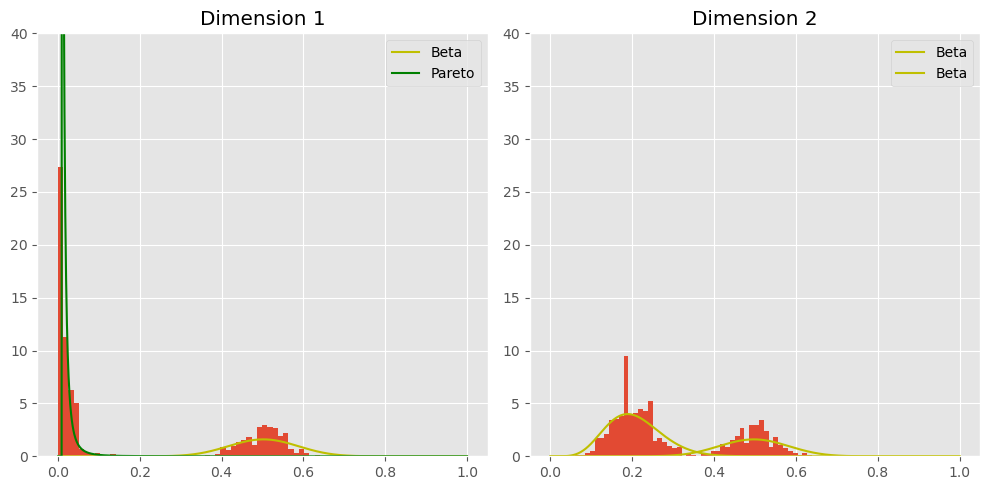

Iteration 600: Loss = -5276707.5
Iteration 800: Loss = -8700993.0
probs_beta [[0.5019978  0.49777135]
 [0.0603957  0.19819596]]


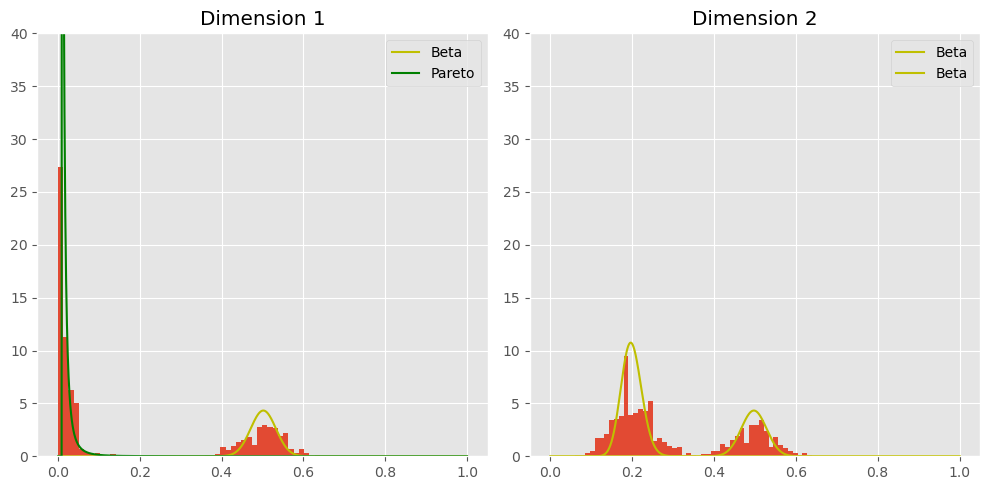

Iteration 1000: Loss = -11132662.0
Iteration 1200: Loss = -13136721.0
probs_beta [[0.50196457 0.4977651 ]
 [0.0544755  0.19813395]]


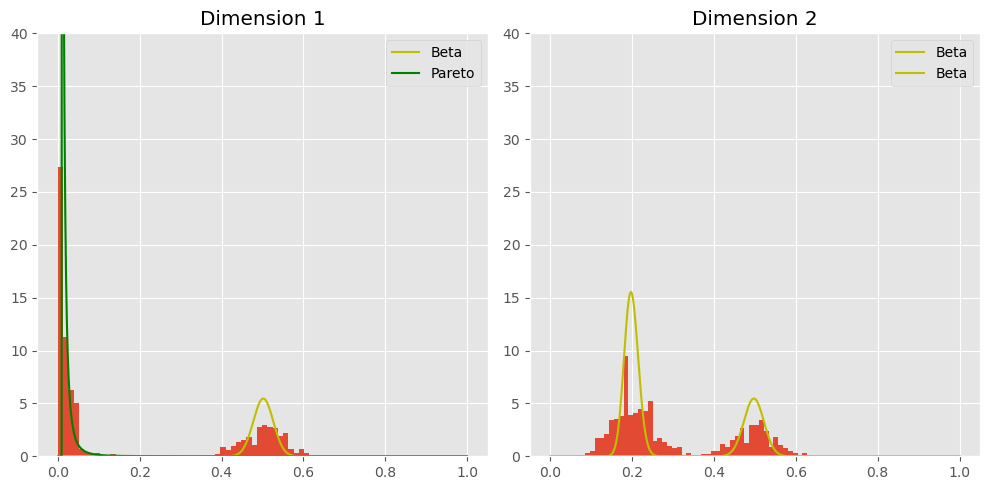

Iteration 1400: Loss = -15175912.0
Iteration 1600: Loss = -17253084.0
probs_beta [[0.5019685  0.49776533]
 [0.05366351 0.19811788]]


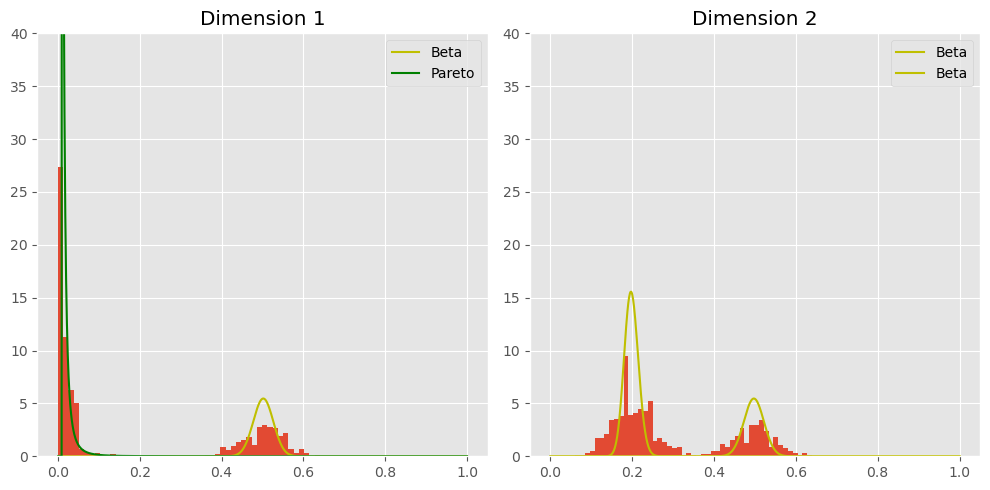

Iteration 1800: Loss = -19361958.0
Iteration 2000: Loss = -21494648.0
probs_beta [[0.50197774 0.49776343]
 [0.05360151 0.1981104 ]]


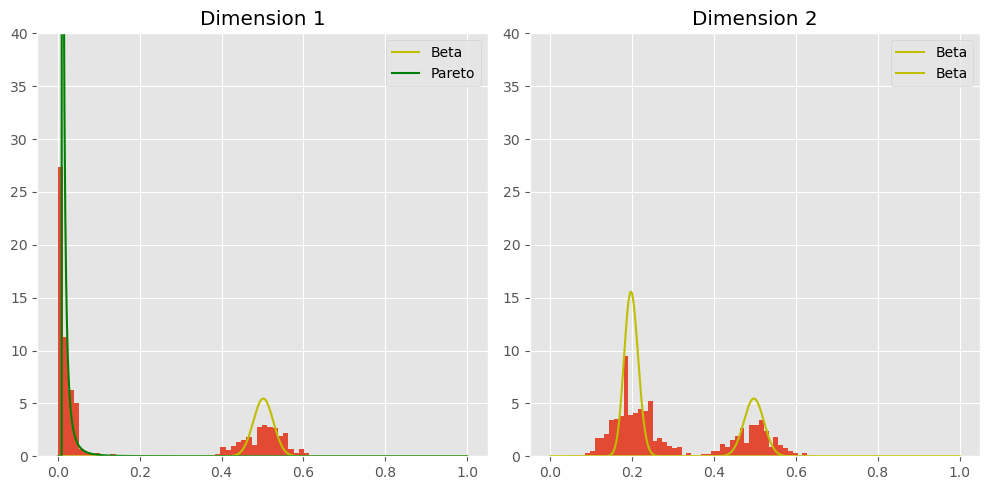

Iteration 2200: Loss = -23648010.0
Iteration 2400: Loss = -25816628.0
probs_beta [[0.5019851  0.49776515]
 [0.05362977 0.1980593 ]]


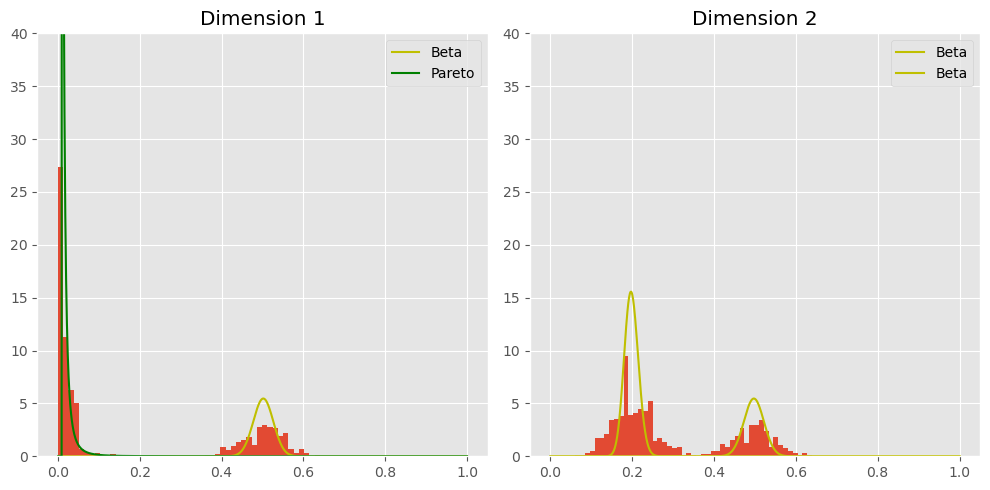

Iteration 2600: Loss = -27997480.0
Iteration 2800: Loss = -33177348.0
probs_beta [[0.5019935  0.4977646 ]
 [0.05413952 0.19808936]]


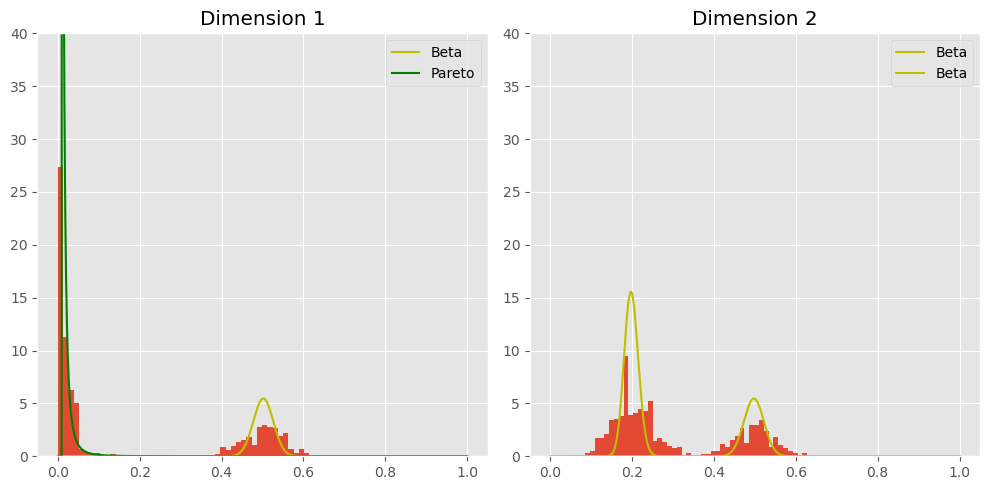

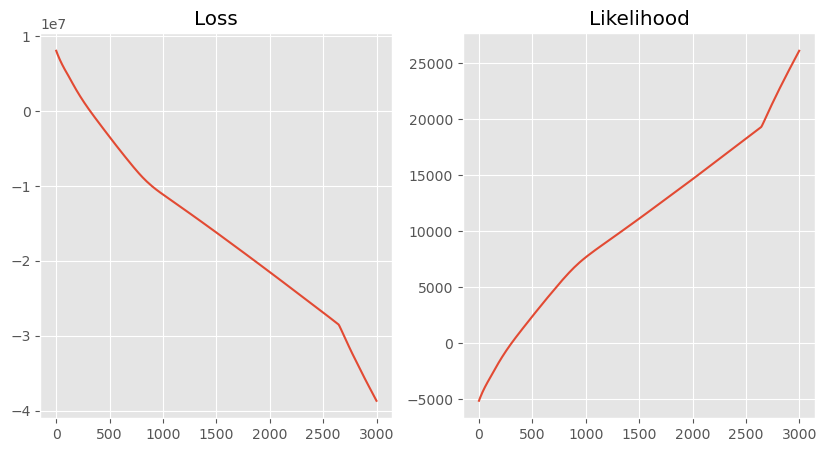

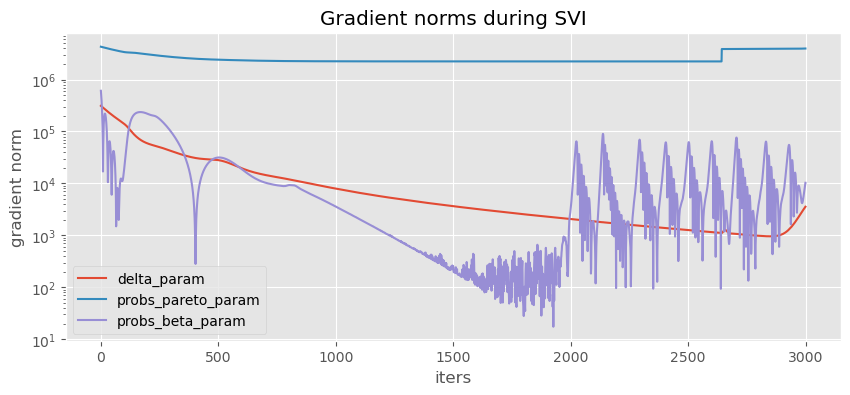

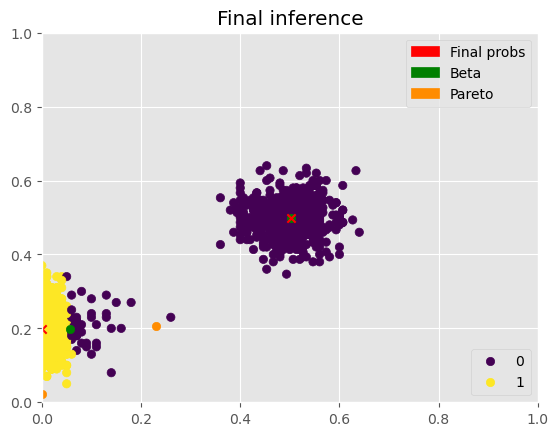

In [39]:
mb = mobster_MV(NV, DP, K = 2, seed = 123)
mb.fit(num_iter = 3000, lr = 0.005)

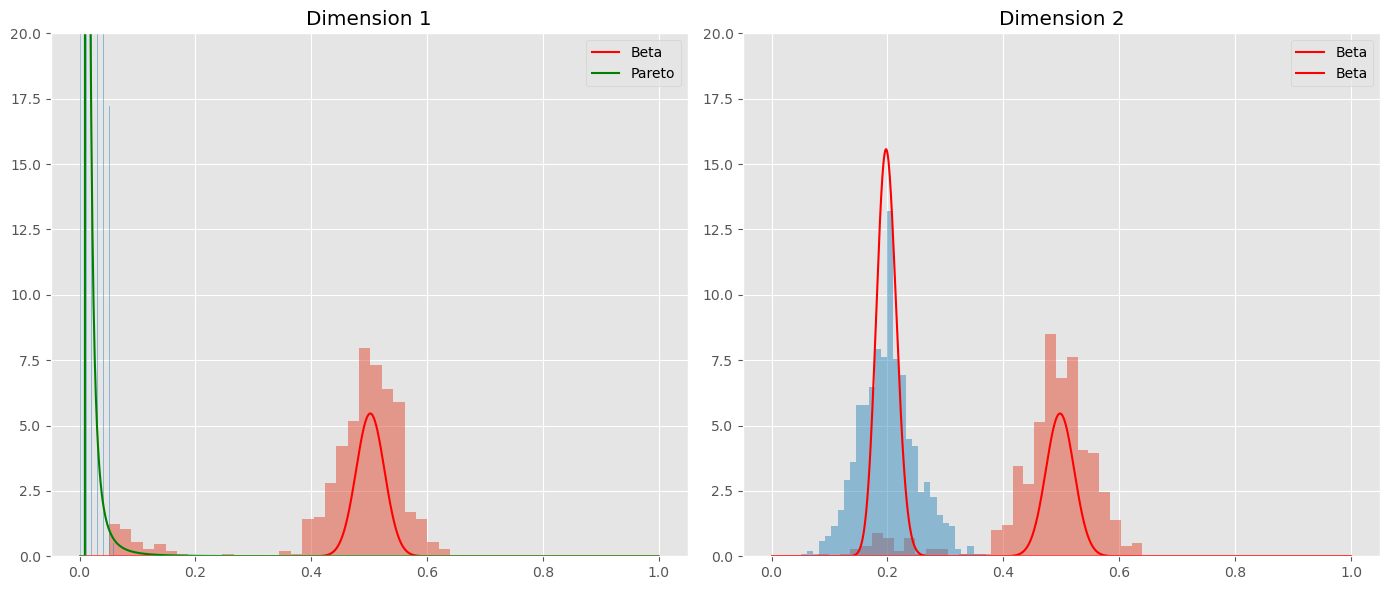

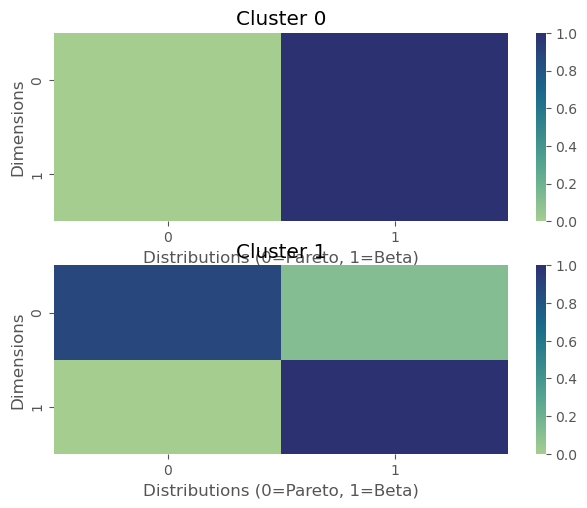

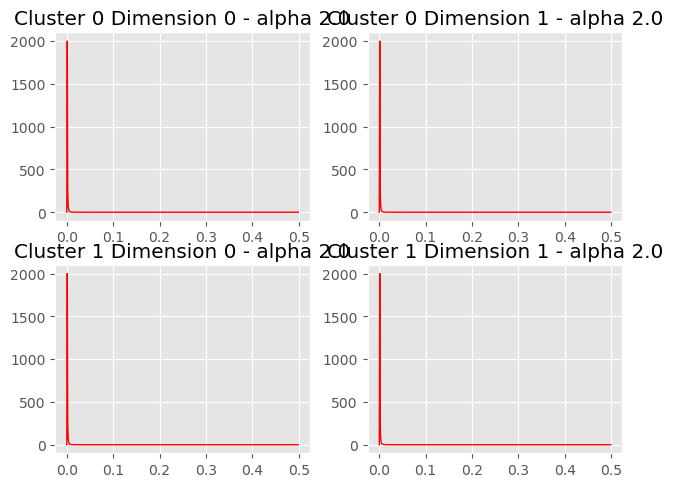

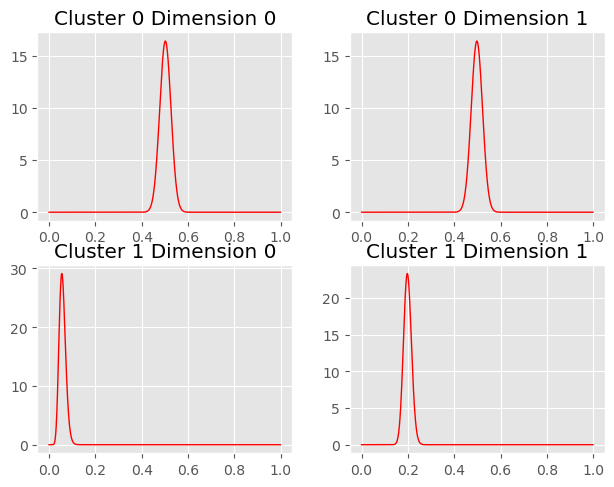

In [40]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [41]:
mb.params

{'probs_beta': tensor([[0.5020, 0.4978],
         [0.0567, 0.1981]]),
 'probs_pareto': tensor([[2.3115e-01, 2.0537e-01],
         [8.5473e-09, 2.1773e-02]]),
 'weights': tensor([0.3334, 0.6666]),
 'delta': tensor([[[4.6546e-04, 9.9953e-01],
          [5.3129e-04, 9.9947e-01]],
 
         [[8.7891e-01, 1.2109e-01],
          [9.1327e-04, 9.9909e-01]]]),
 'alpha_pareto': tensor([[2., 2.],
         [2., 2.]]),
 'phi_beta': tensor([[0.5020, 0.4978],
         [0.0583, 0.1987]]),
 'k_beta': tensor([[422.2840, 422.2752],
         [280.8604, 544.2667]]),
 'responsib': tensor([[9.4888e-38, 2.4594e-35, 2.7225e-23,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 'cluster_assignments': tensor([1, 1, 1,  ..., 0, 0, 0])}

### rRACES data

In [42]:
NV_r = pd.read_csv("../rRACES_data/NV2.csv")
DP_r = pd.read_csv("../rRACES_data/DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([593, 2])
torch.Size([593, 2])


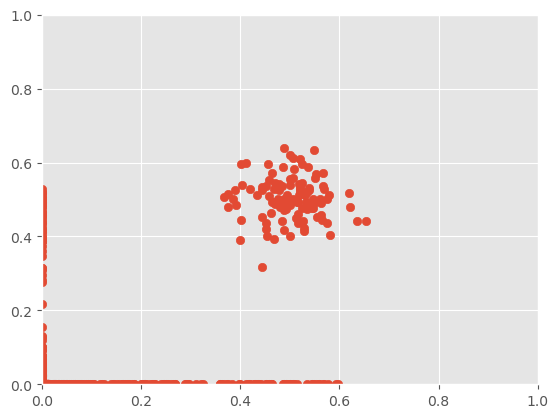

In [43]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

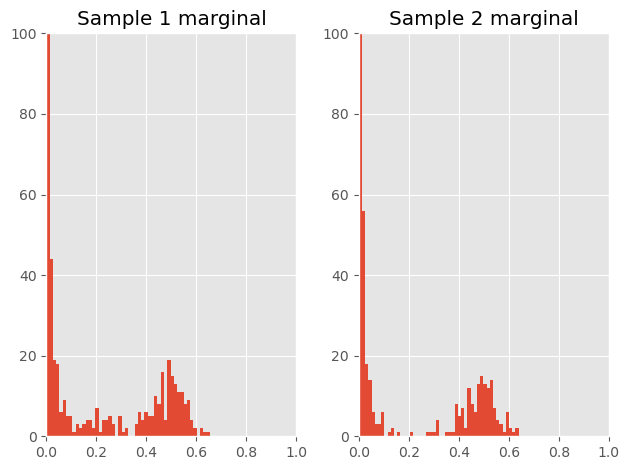

In [44]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


kmeans_centers:  tensor([[2.1703e-01, 1.0000e-03],
        [4.9993e-01, 5.0346e-01],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.0000e-03],
        [1.4685e-02, 1.4474e-02]])


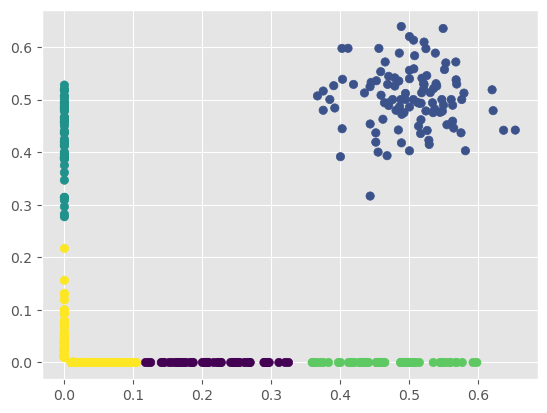

In [45]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


kmeans_centers:  tensor([[2.1703e-01, 1.0000e-03],
        [4.9993e-01, 5.0346e-01],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.0000e-03],
        [1.4685e-02, 1.4474e-02]])
Beta:  tensor([[0.6924, 1.5813],
        [0.5292, 0.5293],
        [1.6094, 0.5387],
        [0.5309, 1.5813],
        [1.3895, 1.3917]])
Pareto:  tensor([[-3.9340, 12.2061],
        [-6.4373, -6.4584],
        [43.4688, -5.9622],
        [-6.2494, 12.2061],
        [ 4.1456,  4.1891]])
Iteration 0: Loss = -1420896.0
weights_param tensor([0.1767, 0.2347, 0.0277, 0.2599, 0.3009], grad_fn=<DivBackward0>)
phi_beta_param tensor([[2.1828e-01, 1.0100e-03],
        [4.9995e-01, 5.0340e-01],
        [3.0102e-08, 4.2740e-01],
        [4.6994e-01, 1.0100e-03],
        [1.4828e-02, 1.4615e-02]], grad_fn=<AddBackward0>)
k_beta_param tensor([[5.0503, 5.0503],
        [5.0503, 5.0503],
        [5.0503, 5.0503],
        [5.0503, 5.0503],
        [5.0503, 5.0503]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[2.

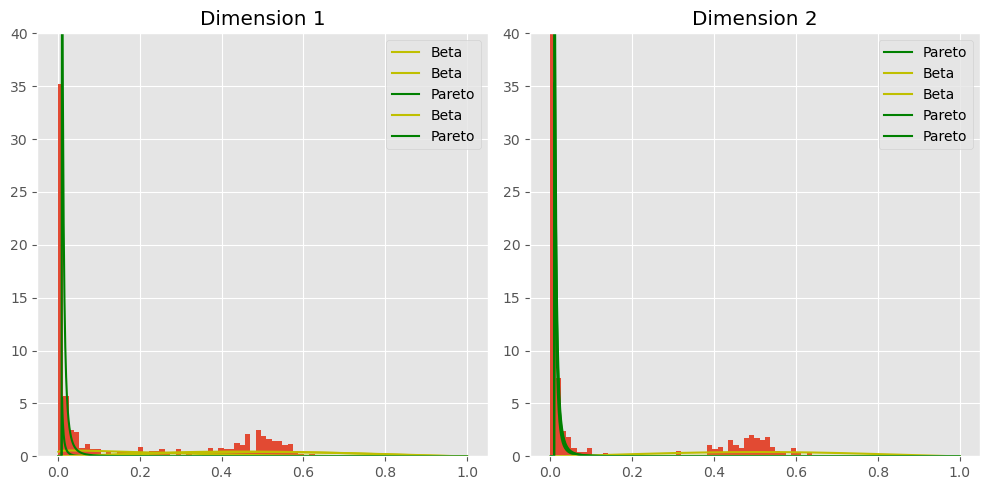

Iteration 200: Loss = -4191952.0
Iteration 400: Loss = -8172422.5
probs_beta [[7.7658258e-02 1.5907591e-04]
 [4.9902999e-01 5.0187629e-01]
 [3.9945229e-09 1.3182682e-01]
 [4.0223563e-01 1.5733010e-04]
 [9.6776495e-03 8.9168176e-03]]


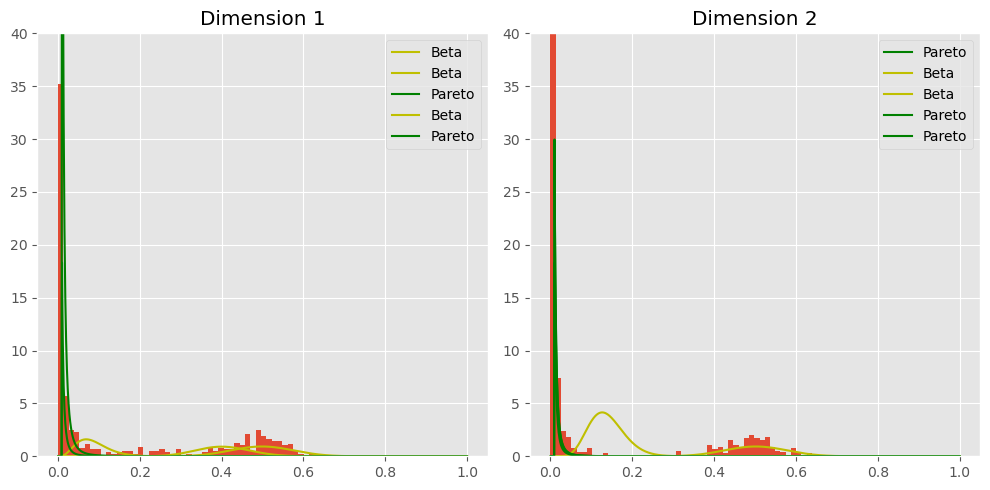

Iteration 600: Loss = -10549725.0
Iteration 800: Loss = -11814925.0
probs_beta [[8.8430367e-02 3.2032014e-05]
 [4.9902952e-01 5.0187618e-01]
 [5.4078142e-10 4.2719595e-02]
 [4.0069717e-01 3.1270949e-05]
 [9.8026143e-03 8.9993635e-03]]


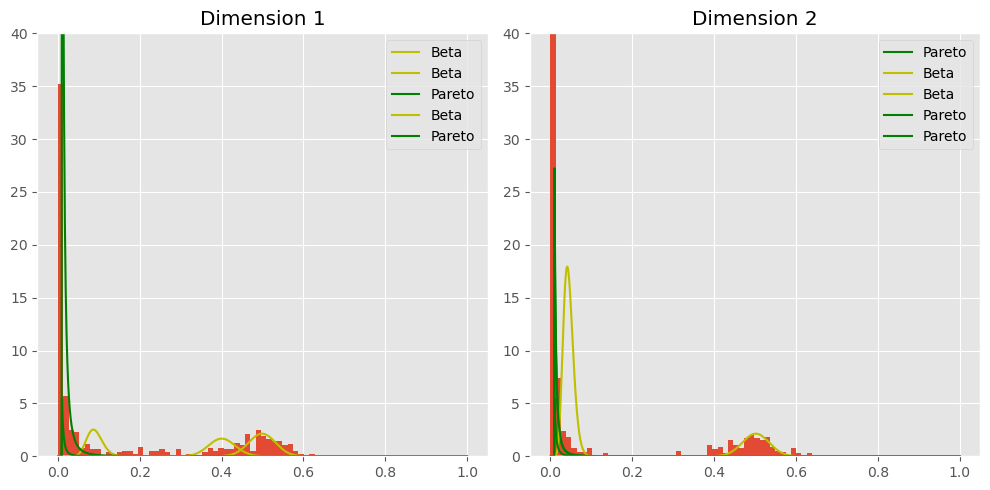

Iteration 1000: Loss = -12867000.0
Iteration 1200: Loss = -13841281.0
probs_beta [[9.6607246e-02 4.2308625e-06]
 [4.9902999e-01 5.0187635e-01]
 [7.3292414e-11 2.2815462e-02]
 [3.9276439e-01 4.0976165e-06]
 [9.9796886e-03 9.1161840e-03]]


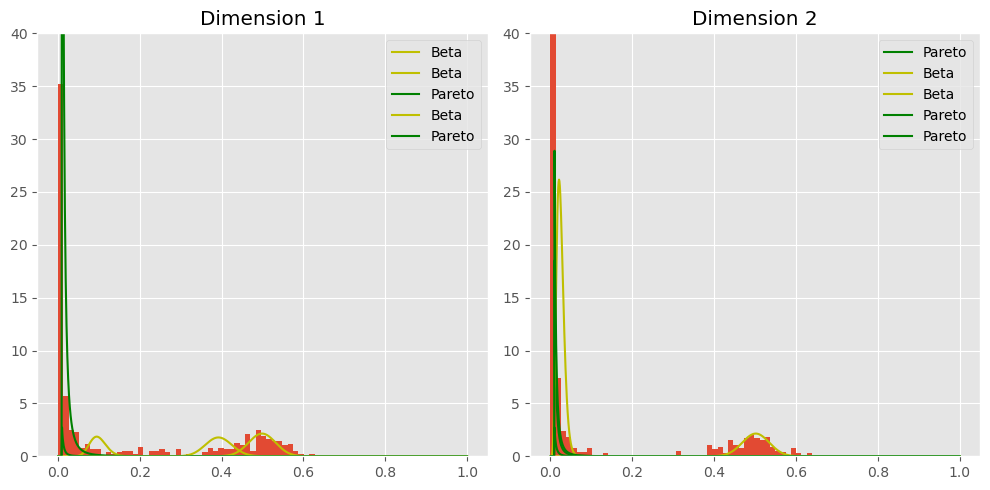

Iteration 1400: Loss = -14773876.0
Iteration 1600: Loss = -15743520.0
probs_beta [[9.3132861e-02 5.1248691e-07]
 [4.9902999e-01 5.0187624e-01]
 [1.0018855e-11 1.5649011e-02]
 [3.6663532e-01 4.9450830e-07]
 [1.0175876e-02 9.2455028e-03]]


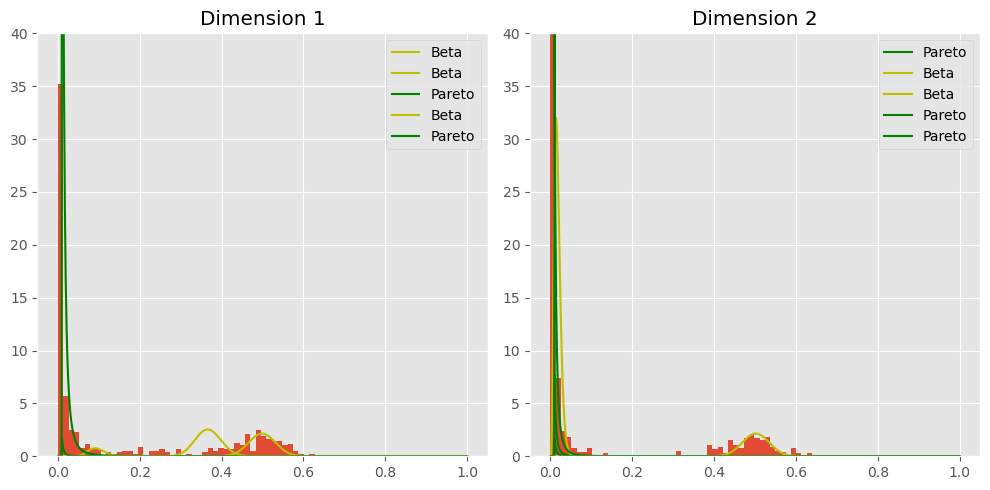

Iteration 1800: Loss = -16789110.0
Iteration 2000: Loss = -17774678.0
probs_beta [[1.0094382e-01 6.1482496e-08]
 [4.9903038e-01 5.0187582e-01]
 [1.4097643e-12 1.2822140e-02]
 [3.5731494e-01 5.9227148e-08]
 [1.0373112e-02 9.3757557e-03]]


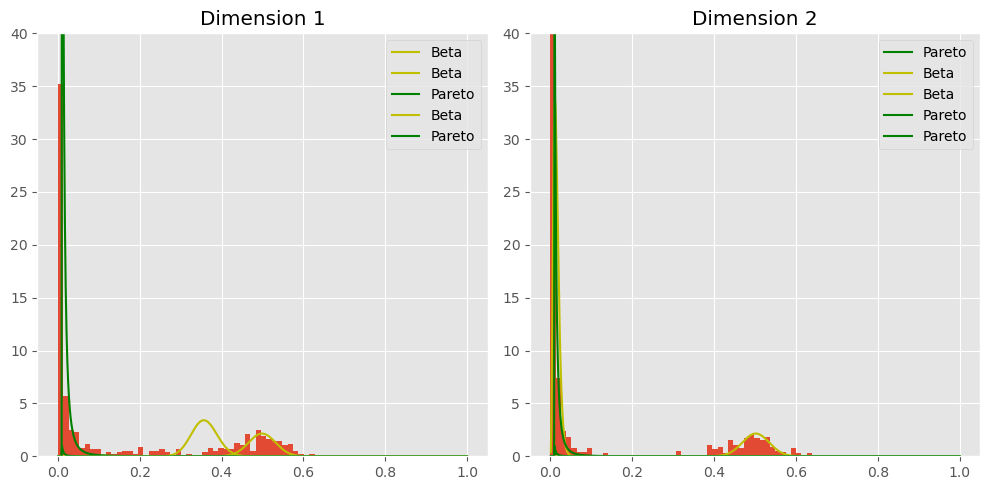

Iteration 2200: Loss = -18724572.0
Iteration 2400: Loss = -19651650.0
probs_beta [[1.0094042e-01 7.4686897e-09]
 [4.9903038e-01 5.0187629e-01]
 [2.0050735e-13 1.1374879e-02]
 [3.5715491e-01 7.1895037e-09]
 [1.0551844e-02 9.4946139e-03]]


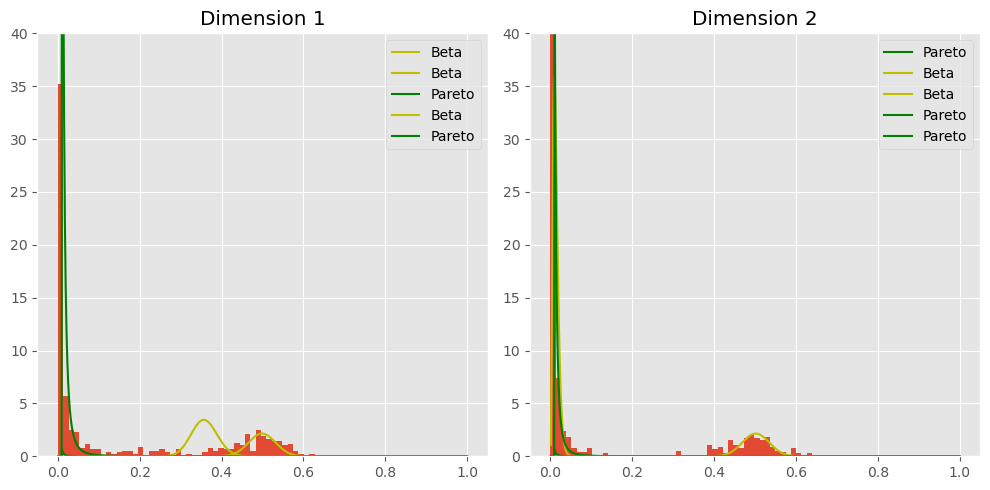

Iteration 2600: Loss = -20563580.0
Iteration 2800: Loss = -21465002.0
probs_beta [[1.0093656e-01 9.2282787e-10]
 [4.9902904e-01 5.0187629e-01]
 [2.7975321e-14 1.0595610e-02]
 [3.5714227e-01 8.8807606e-10]
 [1.0691853e-02 9.5892278e-03]]


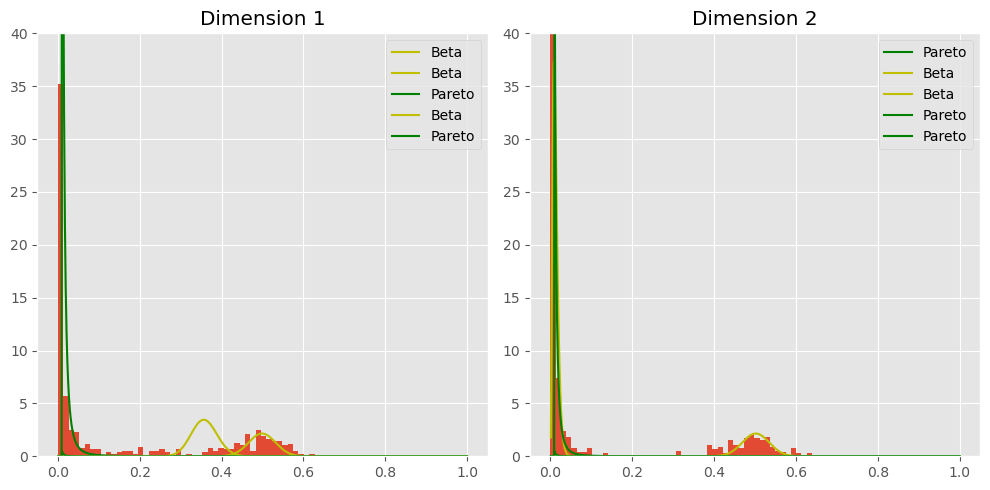

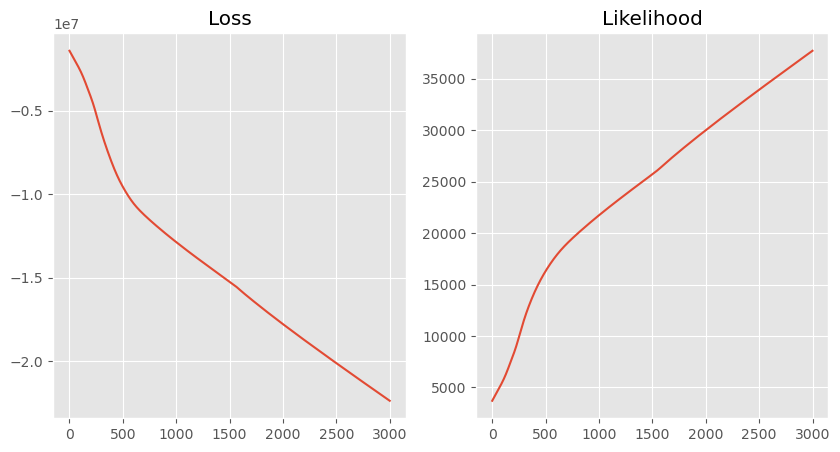

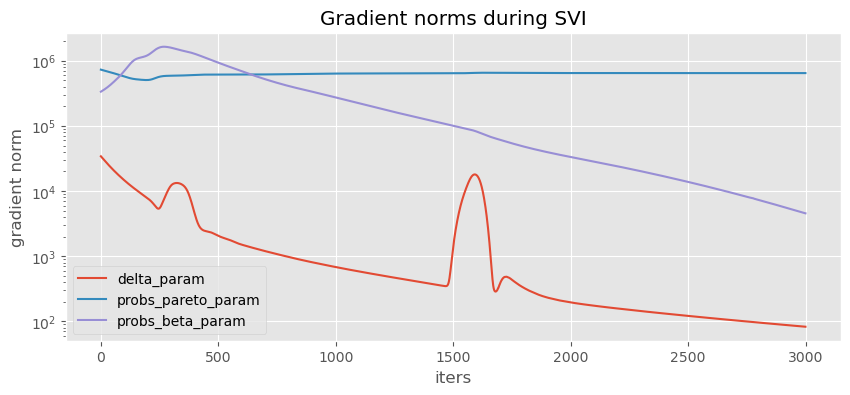

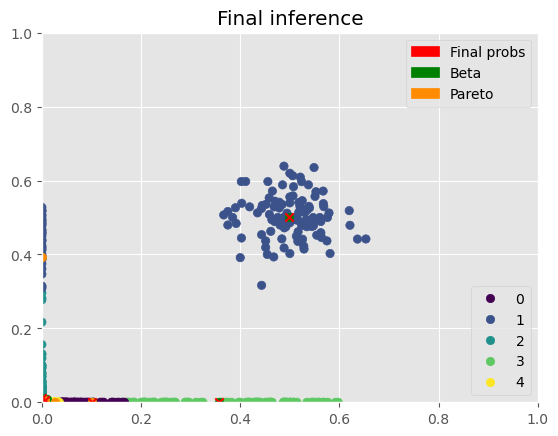

In [46]:
mb = mobster_MV(NV, DP, K = 5, seed = 123)
mb.fit(num_iter = 3000, lr = 0.005)

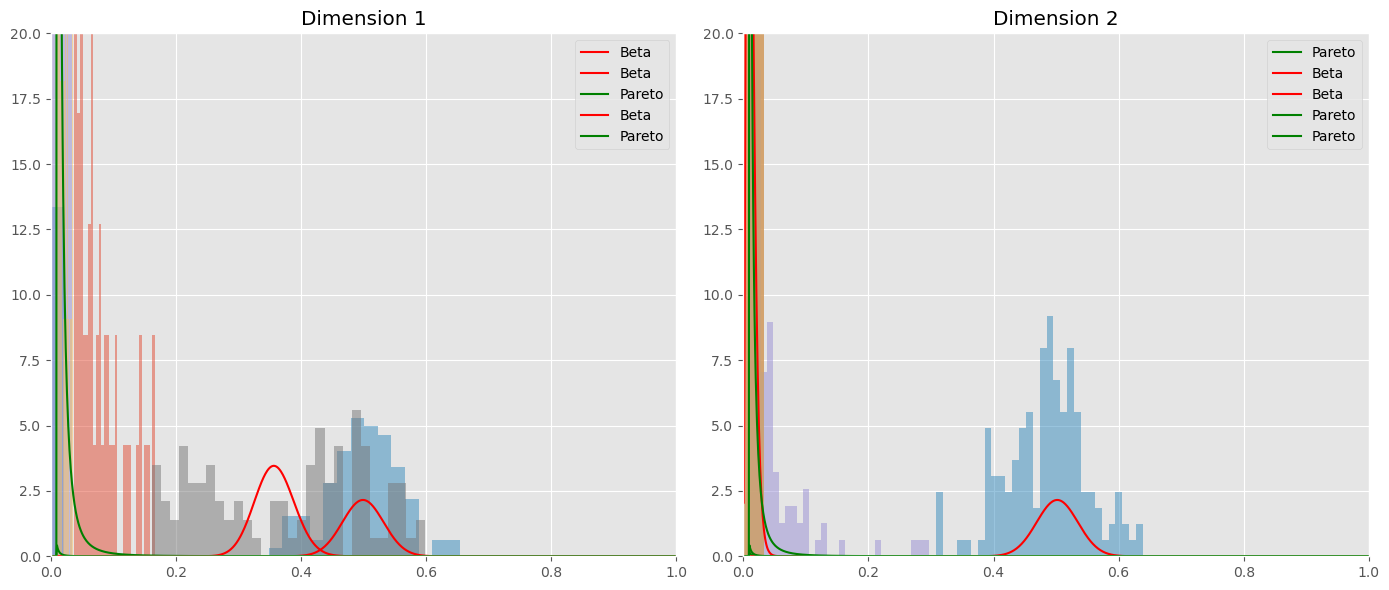

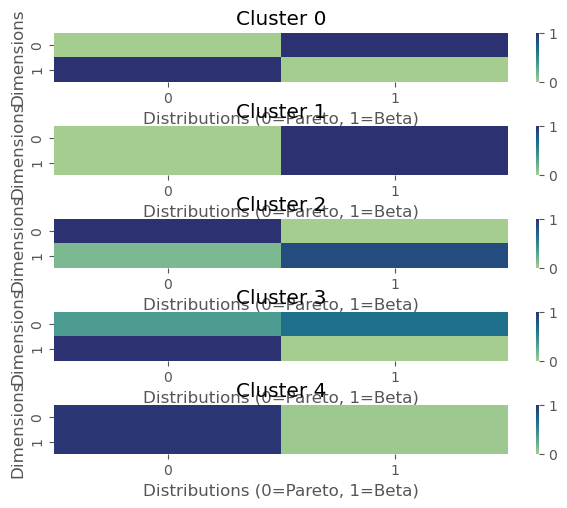

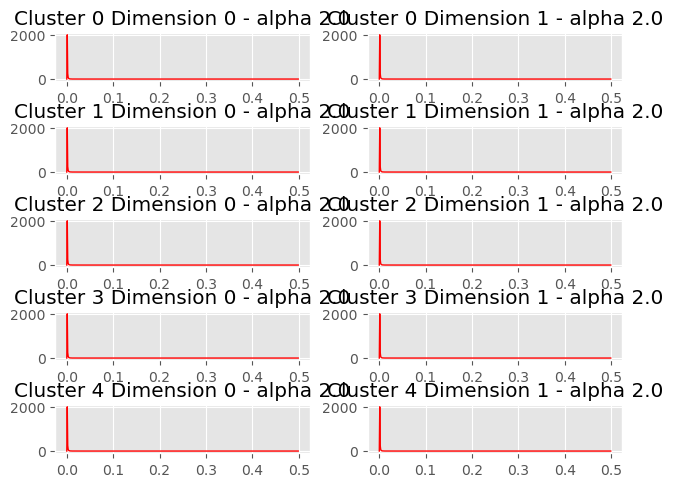

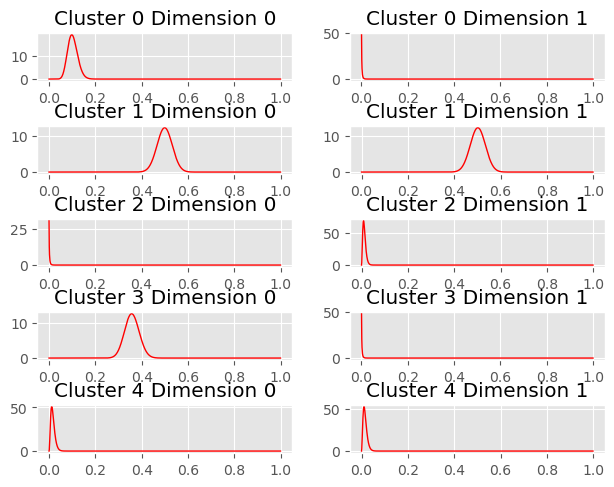

In [47]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [48]:
mb.params

{'probs_beta': tensor([[1.0093e-01, 3.2809e-10],
         [4.9903e-01, 5.0188e-01],
         [1.0434e-14, 1.0373e-02],
         [3.5710e-01, 3.1571e-10],
         [1.0741e-02, 9.6232e-03]]),
 'probs_pareto': tensor([[1.0166e-01, 1.1645e-06],
         [1.3574e-07, 1.6643e-07],
         [2.7781e-15, 3.9340e-01],
         [2.6099e-02, 2.4307e-11],
         [6.3997e-03, 5.9236e-03]]),
 'weights': tensor([0.0007, 0.1769, 0.5481, 0.2723, 0.0021]),
 'delta': tensor([[[1.9488e-03, 9.9805e-01],
          [9.9809e-01, 1.9071e-03]],
 
         [[4.5198e-04, 9.9955e-01],
          [4.5200e-04, 9.9955e-01]],
 
         [[9.9980e-01, 1.9714e-04],
          [1.4708e-01, 8.5292e-01]],
 
         [[3.5269e-01, 6.4731e-01],
          [9.9980e-01, 2.0469e-04]],
 
         [[9.7131e-01, 2.8690e-02],
          [9.7140e-01, 2.8603e-02]]]),
 'alpha_pareto': tensor([[2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.]]),
 'phi_beta': tensor([[1.0216e-01, 3.1432e-04],
         [

### rRACES longitudinal data

In [49]:
NV_r = pd.read_csv("../rRACES_data/NV_long.csv")
DP_r = pd.read_csv("../rRACES_data/DP_long.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([1224, 2])
torch.Size([1224, 2])


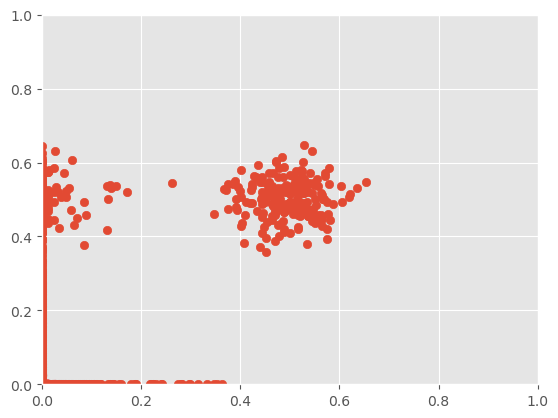

In [50]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

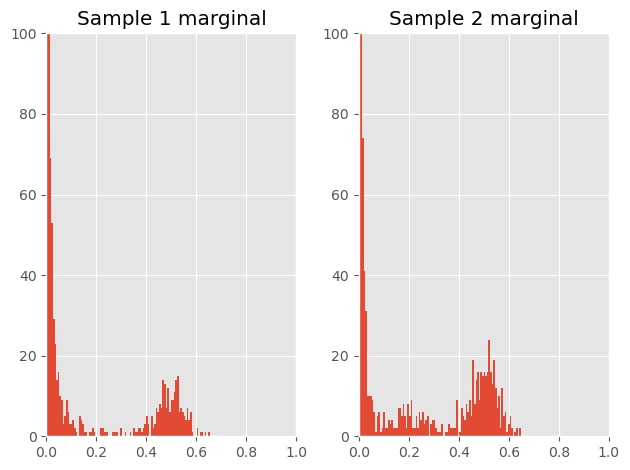

In [51]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 100)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 100)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[1.4442e-02, 1.1785e-02],
        [4.9358e-01, 5.0280e-01],
        [1.6109e-02, 4.9525e-01],
        [2.2913e-01, 1.0000e-03],
        [2.2352e-08, 2.1557e-01]])


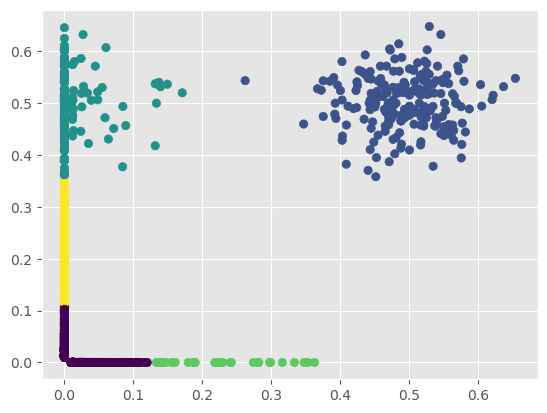

In [52]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

kmeans_centers:  tensor([[2.2878e-02, 1.1322e-02],
        [4.4452e-01, 4.9081e-01],
        [1.6109e-02, 4.9525e-01],
        [5.3156e-01, 5.1208e-01],
        [2.2352e-08, 2.1557e-01]])
Beta:  tensor([[1.3140, 1.4259],
        [0.5346, 0.5294],
        [1.3752, 0.5293],
        [0.5310, 0.5295],
        [1.6094, 0.6944]])
Pareto:  tensor([[ 2.8155,  4.9258],
        [-6.0849, -6.3821],
        [ 3.8680, -6.4091],
        [-6.6214, -6.5094],
        [44.3319, -3.9138]])
Iteration 0: Loss = -21629672.0
weights_param tensor([0.3161, 0.1105, 0.2489, 0.0579, 0.2665], grad_fn=<DivBackward0>)
phi_beta_param tensor([[2.3098e-02, 1.1433e-02],
        [4.4509e-01, 4.9099e-01],
        [1.6266e-02, 4.9539e-01],
        [5.1000e-01, 5.1000e-01],
        [2.2576e-08, 2.1682e-01]], grad_fn=<AddBackward0>)
k_beta_param tensor([[5.0503, 5.0503],
        [5.0502, 5.0502],
        [5.0503, 5.0503],
        [5.0503, 5.0503],
        [5.0503, 5.0503]], grad_fn=<AddBackward0>)
probs_beta_param tensor([[2

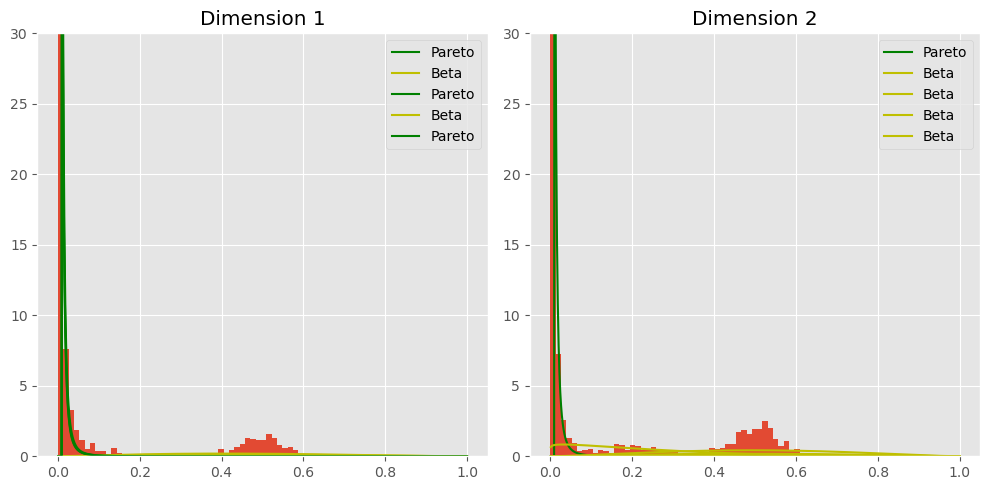

Iteration 200: Loss = -34202256.0
Iteration 400: Loss = -42102240.0
probs_beta [[1.4238065e-01 6.7339358e-03]
 [4.5885819e-01 4.9147755e-01]
 [1.0965486e-01 5.0349545e-01]
 [5.0999939e-01 5.0999576e-01]
 [2.9958880e-09 6.0810279e-02]]


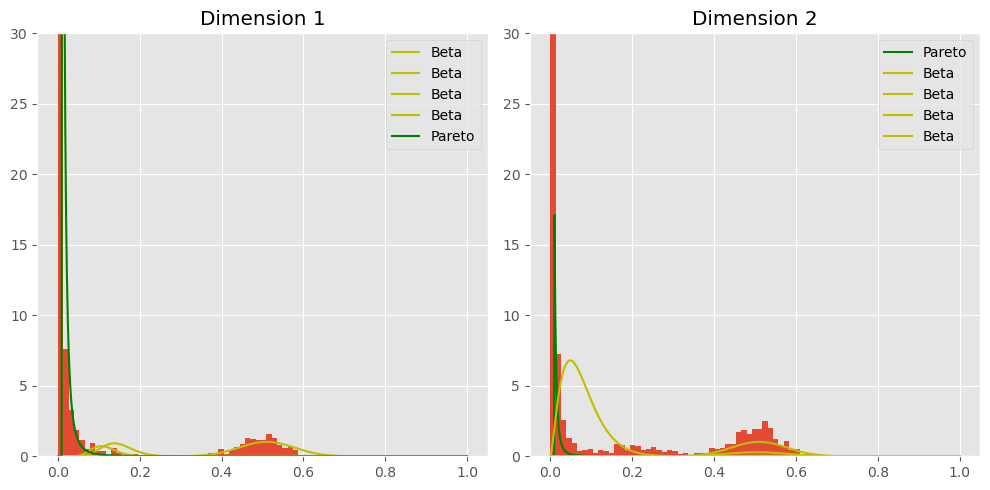

Iteration 600: Loss = -47669108.0
Iteration 800: Loss = -52179416.0
probs_beta [[1.4428656e-01 6.7826556e-03]
 [4.5507950e-01 4.8935160e-01]
 [1.0151416e-01 5.0225610e-01]
 [5.0946176e-01 5.0689054e-01]
 [4.0558548e-10 3.0589089e-02]]


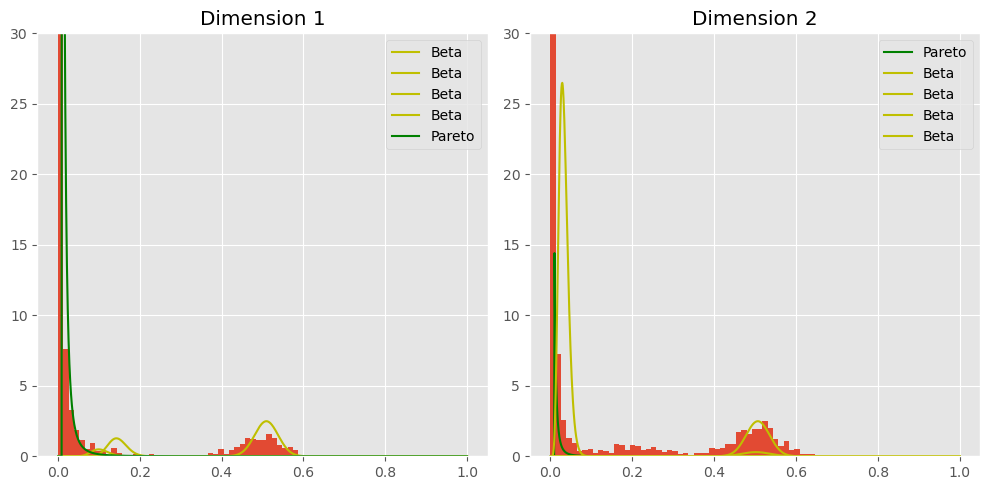

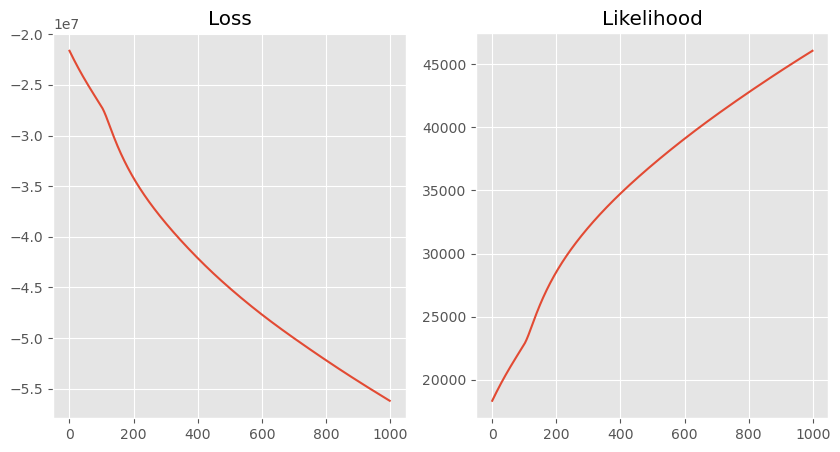

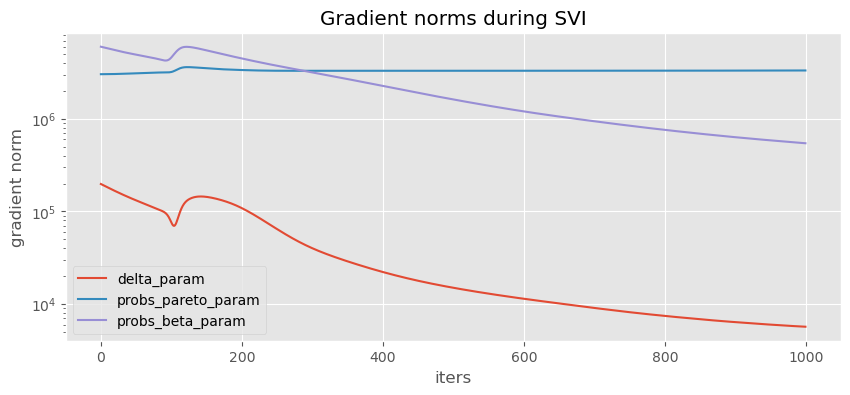

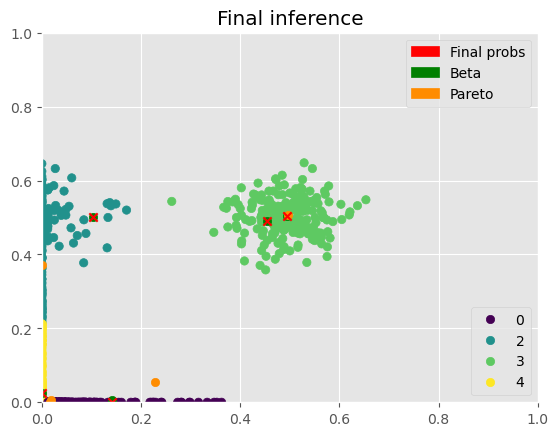

In [53]:
mb = mobster_MV(NV, DP, K = 5, seed = 25)
mb.fit(num_iter = 1000, lr = 0.005)

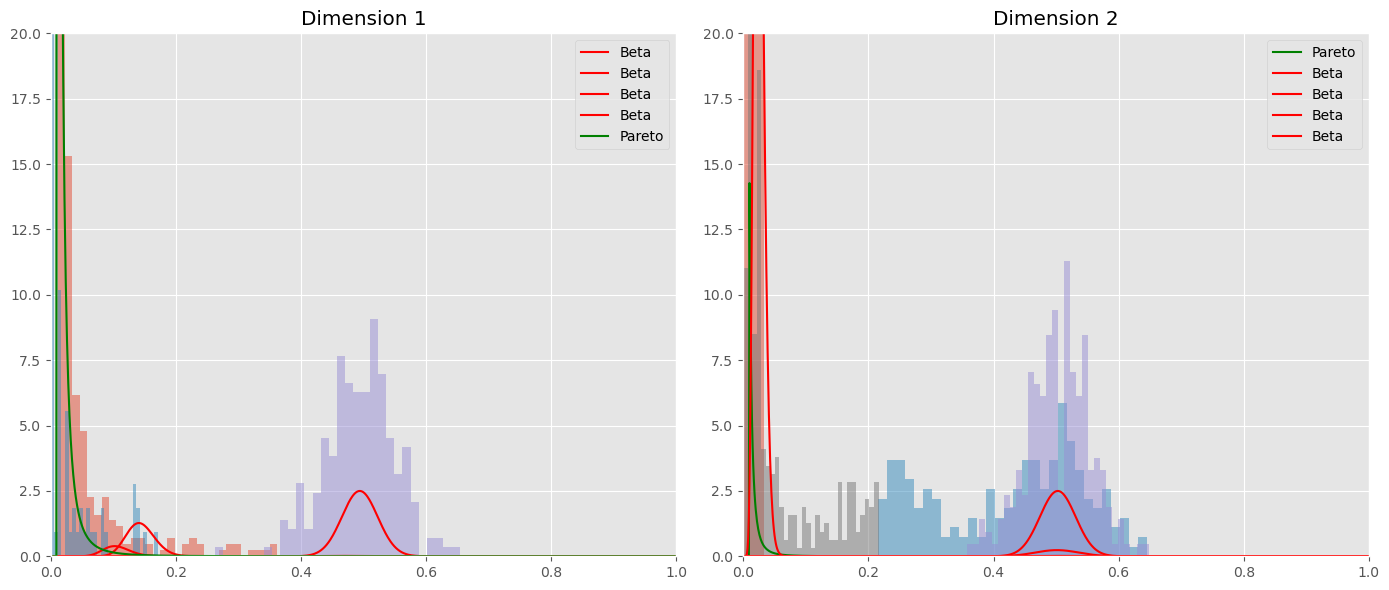

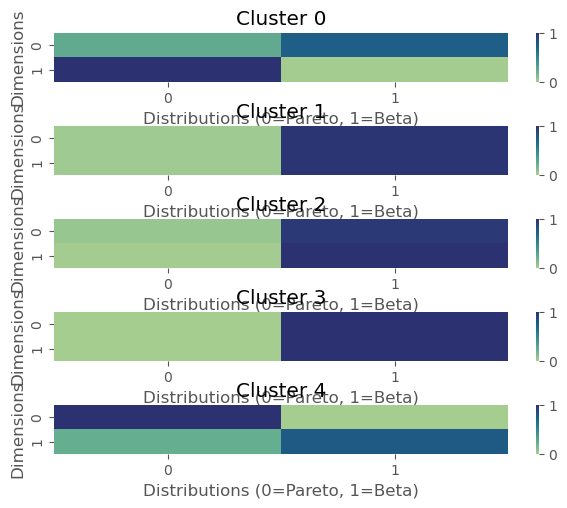

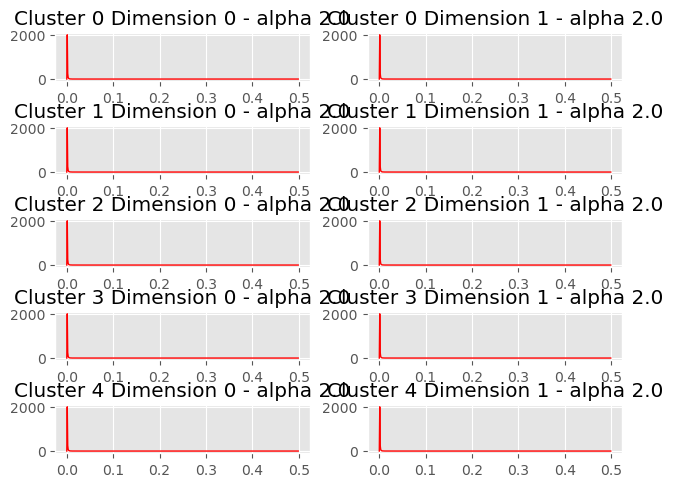

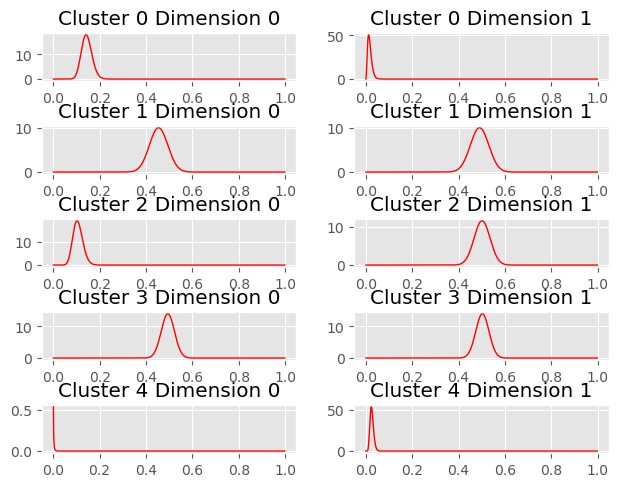

In [54]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [55]:
mb.params

{'probs_beta': tensor([[1.4232e-01, 6.8140e-03],
         [4.5352e-01, 4.9065e-01],
         [1.0400e-01, 5.0132e-01],
         [4.9396e-01, 5.0269e-01],
         [1.4999e-10, 2.4298e-02]]),
 'probs_pareto': tensor([[1.7362e-02, 2.2959e-04],
         [2.2827e-01, 5.4191e-02],
         [1.8772e-02, 5.2546e-03],
         [4.9644e-01, 5.0635e-01],
         [1.3311e-10, 3.7152e-01]]),
 'weights': tensor([0.0714, 0.0016, 0.0204, 0.1784, 0.7283]),
 'delta': tensor([[[0.2535, 0.7465],
          [0.9949, 0.0051]],
 
         [[0.0215, 0.9785],
          [0.0209, 0.9791]],
 
         [[0.0479, 0.9521],
          [0.0044, 0.9956]],
 
         [[0.0018, 0.9982],
          [0.0018, 0.9982]],
 
         [[0.9970, 0.0030],
          [0.2281, 0.7719]]]),
 'alpha_pareto': tensor([[2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.],
         [2., 2.]]),
 'phi_beta': tensor([[1.4380e-01, 1.6565e-02],
         [4.5437e-01, 4.9062e-01],
         [1.0586e-01, 5.0132e-01],
         [4.9397e-01